In [1]:
import os
import cv2
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device('mps')

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 32

In [2]:
import cv2
import numpy as np

def frames_extractor(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for frame_counter in range(0, video_frames_count, skip_frames_window):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(face, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_face = resized_face / 255.0
            frames_list.append(normalized_face)
 
       # Stop if we have collected enough frames
        if len(frames_list) >= SEQUENCE_LENGTH:
            break

    video_reader.release()

    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))  

    return frames_list

In [3]:
import os
import numpy as np

def create_dataset(root_dir, classes_list):
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(classes_list):
        class_dir = os.path.join(root_dir, class_name)
        
        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            frames = frames_extractor(video_file_path)
            
            # Check if the extracted frames match the SEQUENCE_LENGTH
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    
    # Convert lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

# Set your root directory and classes list
DATASET_DIR = "Celeb-DF-v2"
CLASSES_LIST = ["Real", "SyntheticVid"]


features, labels, video_files_paths = create_dataset(DATASET_DIR, CLASSES_LIST)

OpenCV: Couldn't read video stream from file "Celeb-DF-v2/SyntheticVid/.DS_Store"


In [4]:
import torch
import torch.nn as nn
from torchvision import models

class TemporalAttention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
      
        u = torch.tanh(self.fc1(x))  
        a = torch.softmax(self.fc2(u), dim=1)  
        x_attended = (a * x).sum(dim=1)  
        return x_attended

class EfficientNetTemporalAttentionModel(nn.Module):
    def __init__(self, num_classes, hidden_dim=128):
        super(EfficientNetTemporalAttentionModel, self).__init__()
        
        efficientnet = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(efficientnet.children())[:-1])
        feature_dim = efficientnet.classifier[1].in_features
        
        self.temporal_attention = TemporalAttention(feature_dim, hidden_dim)
        
        self.fc = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        batch_size, num_frames, channels, height, width = x.size()
        
        x = x.view(batch_size * num_frames, channels, height, width)  
        features = self.feature_extractor(x)  
        features = features.view(batch_size, num_frames, -1)  
        attended_features = self.temporal_attention(features)

        output = self.fc(attended_features)
        return output


num_classes = len(CLASSES_LIST)
model = EfficientNetTemporalAttentionModel(num_classes).to(device)


/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torchvision.models as models
class LightVideoModelWithLSTM(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=256, num_layers=1, use_gru=False):
        super(LightVideoModelWithLSTM, self).__init__()
        
        # Load a lightweight ResNet model and remove the final classification layer
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # [B*frames, 512, 1, 1]
        
        # RNN Layer (LSTM or GRU) to process temporal information
        self.use_gru = use_gru
        rnn_module = nn.GRU if use_gru else nn.LSTM
        self.rnn = rnn_module(input_size=512, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Fully-connected layer as a lightweight classifier
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Reshape input to [B*frames, ch, w, h]
        B, frames, ch, w, h = x.size()
        x = x.view(B * frames, ch, w, h)  # Flatten batch and frames
        
        # Pass through ResNet feature extractor
        features = self.feature_extractor(x)  # Output shape: [B*frames, 512, 1, 1]
        features = features.view(B, frames, -1)  # Reshape to [B, frames, 512]

        # Pass frame-level features through RNN
        rnn_out, _ = self.rnn(features)  # Output shape: [B, frames, hidden_dim]
        
        # Use the output from the last frame
        final_features = rnn_out[:, -1, :]  # Shape: [B, hidden_dim]

        # Pass through the classifier
        output = self.fc(final_features)  # Shape: [B, num_classes]
        return output

In [6]:
import torch

# Set device
device = torch.device("mps")

# Dummy input parameters
batch_size = 2       # Number of videos in a batch
num_frames = 10      # Number of frames per video
channels = 3         # RGB channels
height = 224         # Frame height
width = 224          # Frame width
num_classes = len(CLASSES_LIST)  # Define this based on your class list

# Initialize the model
model = LightVideoModelWithLSTM(num_classes=num_classes, use_gru=True).to(device)

# Print the model architecture
print(model)

# Create a dummy input tensor
dummy_input = torch.randn(batch_size, num_frames, channels, height, width).to(device)

# Run a forward pass
output = model(dummy_input)

# Check output shape
print(f"Output shape: {output.shape}")  # Expected: (batch_size, num_classes)

# Check weights in EfficientNet, Temporal Attention, and Classifier



/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LightVideoModelWithLSTM(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, shuffle=True)

features_train = torch.tensor(features_train).float().permute(0, 1, 4, 2, 3).to(device)  
features_test = torch.tensor(features_test).float().permute(0, 1, 4, 2, 3).to(device)
labels_train = torch.tensor(labels_train).long().to(device)
labels_test = torch.tensor(labels_test).long().to(device)

In [8]:
class VideoDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = VideoDataset(features_train, labels_train)
test_dataset = VideoDataset(features_test, labels_test)

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

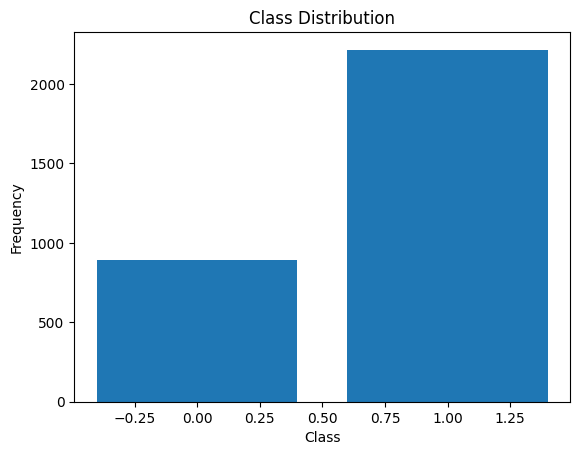

In [9]:
import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = LightVideoModelWithLSTM(num_classes=num_classes, use_gru=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_accuracy = []
train_loss = []

# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Get predictions and update accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=100. * correct / total if total > 0 else 0)
            pbar.update(1)

    # Print loss and accuracy at the end of the epoch
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = 100. * correct / total if total > 0 else 0  # Avoid division by zero
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%")


Epoch 1/30: 100%|██████████| 621/621 [00:50<00:00, 12.39batch/s, accuracy=80.3, loss=0.443]


Epoch [1/30], Loss: 0.4433, Accuracy: 80.27%


Epoch 2/30: 100%|██████████| 621/621 [00:48<00:00, 12.69batch/s, accuracy=88.6, loss=0.283]


Epoch [2/30], Loss: 0.2831, Accuracy: 88.61%


Epoch 3/30: 100%|██████████| 621/621 [00:48<00:00, 12.69batch/s, accuracy=91.1, loss=0.222]


Epoch [3/30], Loss: 0.2219, Accuracy: 91.10%


Epoch 4/30: 100%|██████████| 621/621 [00:49<00:00, 12.67batch/s, accuracy=92.5, loss=0.195]


Epoch [4/30], Loss: 0.1952, Accuracy: 92.51%


Epoch 5/30: 100%|██████████| 621/621 [00:49<00:00, 12.65batch/s, accuracy=94.5, loss=0.141] 


Epoch [5/30], Loss: 0.1408, Accuracy: 94.52%


Epoch 6/30: 100%|██████████| 621/621 [00:49<00:00, 12.62batch/s, accuracy=95.7, loss=0.114] 


Epoch [6/30], Loss: 0.1144, Accuracy: 95.73%


Epoch 7/30: 100%|██████████| 621/621 [00:49<00:00, 12.61batch/s, accuracy=96.8, loss=0.0967]


Epoch [7/30], Loss: 0.0967, Accuracy: 96.78%


Epoch 8/30: 100%|██████████| 621/621 [00:49<00:00, 12.64batch/s, accuracy=96.3, loss=0.0916]


Epoch [8/30], Loss: 0.0916, Accuracy: 96.30%


Epoch 9/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=98.5, loss=0.0436]


Epoch [9/30], Loss: 0.0436, Accuracy: 98.47%


Epoch 10/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=97.7, loss=0.0648]


Epoch [10/30], Loss: 0.0648, Accuracy: 97.75%


Epoch 11/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=97.7, loss=0.0687]


Epoch [11/30], Loss: 0.0687, Accuracy: 97.75%


Epoch 12/30: 100%|██████████| 621/621 [00:49<00:00, 12.56batch/s, accuracy=98.1, loss=0.0559]


Epoch [12/30], Loss: 0.0559, Accuracy: 98.11%


Epoch 13/30: 100%|██████████| 621/621 [00:49<00:00, 12.57batch/s, accuracy=98.3, loss=0.0564]


Epoch [13/30], Loss: 0.0564, Accuracy: 98.27%


Epoch 14/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=98.3, loss=0.0531]


Epoch [14/30], Loss: 0.0531, Accuracy: 98.27%


Epoch 15/30: 100%|██████████| 621/621 [00:49<00:00, 12.56batch/s, accuracy=98.8, loss=0.0408]


Epoch [15/30], Loss: 0.0408, Accuracy: 98.75%


Epoch 16/30: 100%|██████████| 621/621 [00:49<00:00, 12.60batch/s, accuracy=98.8, loss=0.0295]


Epoch [16/30], Loss: 0.0295, Accuracy: 98.75%


Epoch 17/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=98.6, loss=0.047] 


Epoch [17/30], Loss: 0.0470, Accuracy: 98.55%


Epoch 18/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=98.6, loss=0.0506]


Epoch [18/30], Loss: 0.0506, Accuracy: 98.59%


Epoch 19/30: 100%|██████████| 621/621 [00:49<00:00, 12.57batch/s, accuracy=99.2, loss=0.0287]


Epoch [19/30], Loss: 0.0287, Accuracy: 99.15%


Epoch 20/30: 100%|██████████| 621/621 [00:49<00:00, 12.58batch/s, accuracy=98.7, loss=0.0378]


Epoch [20/30], Loss: 0.0378, Accuracy: 98.71%


Epoch 21/30: 100%|██████████| 621/621 [00:49<00:00, 12.56batch/s, accuracy=99, loss=0.0342]  


Epoch [21/30], Loss: 0.0342, Accuracy: 99.03%


Epoch 22/30: 100%|██████████| 621/621 [00:49<00:00, 12.55batch/s, accuracy=99, loss=0.0299]   


Epoch [22/30], Loss: 0.0299, Accuracy: 98.99%


Epoch 23/30: 100%|██████████| 621/621 [00:49<00:00, 12.52batch/s, accuracy=99.2, loss=0.029] 


Epoch [23/30], Loss: 0.0290, Accuracy: 99.15%


Epoch 24/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=97.9, loss=0.0594]


Epoch [24/30], Loss: 0.0594, Accuracy: 97.87%


Epoch 25/30: 100%|██████████| 621/621 [00:49<00:00, 12.58batch/s, accuracy=99, loss=0.0282]  


Epoch [25/30], Loss: 0.0282, Accuracy: 98.95%


Epoch 26/30: 100%|██████████| 621/621 [00:49<00:00, 12.59batch/s, accuracy=99.8, loss=0.00548]


Epoch [26/30], Loss: 0.0055, Accuracy: 99.84%


Epoch 27/30: 100%|██████████| 621/621 [00:49<00:00, 12.54batch/s, accuracy=99.8, loss=0.00495]


Epoch [27/30], Loss: 0.0049, Accuracy: 99.84%


Epoch 28/30: 100%|██████████| 621/621 [00:49<00:00, 12.58batch/s, accuracy=99.3, loss=0.0189] 


Epoch [28/30], Loss: 0.0189, Accuracy: 99.28%


Epoch 29/30: 100%|██████████| 621/621 [00:49<00:00, 12.58batch/s, accuracy=97.8, loss=0.0617]


Epoch [29/30], Loss: 0.0617, Accuracy: 97.83%


Epoch 30/30: 100%|██████████| 621/621 [00:49<00:00, 12.58batch/s, accuracy=99.7, loss=0.00973]

Epoch [30/30], Loss: 0.0097, Accuracy: 99.68%


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.*correct/total}%")

# Save the Model
torch.save(model.state_dict(), "ResNetGRU_Full.h5")

Test Accuracy: 97.26247987117553%


/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


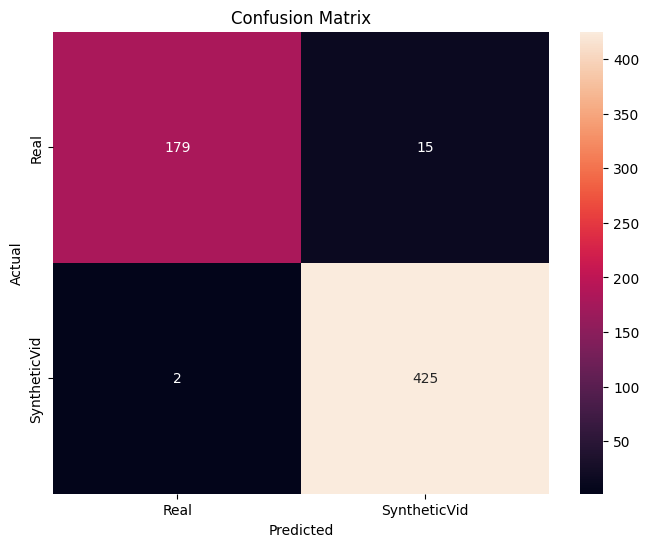

F1 Score: 0.9675


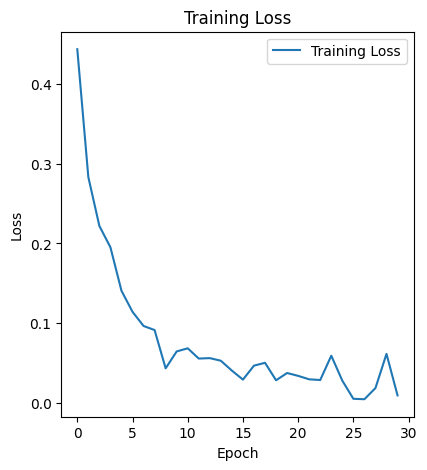

In [14]:
# Load the Model
model = LightVideoModelWithLSTM(num_classes=num_classes, use_gru=True).to(device)
model.load_state_dict(torch.load("ResNetGRU_Full.h5"))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# f1 score
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()


In [13]:
# test on a single video
video_path = "Celeb-DF-v2/Synthetic/id20_id29_0008.mp4"
frames = frames_extractor(video_path)
input_tensor = torch.tensor([frames]).float().permute(0, 1, 4, 2, 3).to(device)
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = outputs.max(1)
    print(f"Predicted Class: {CLASSES_LIST[predicted.item()]}")
    

Predicted Class: SyntheticVid


/var/folders/16/xfx_gvv952jdprrpdvgfy79h0000gn/T/ipykernel_45812/3575966223.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  input_tensor = torch.tensor([frames]).float().permute(0, 1, 4, 2, 3).to(device)
